# **The Impact of Data Sparsity on Recommendation Algorithms: A Comparative Analysis of Memory-Based and Model-Based Approaches**

# Part 0: Setup

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-1m-dataset/users.dat
/kaggle/input/movielens-1m-dataset/ratings.dat
/kaggle/input/movielens-1m-dataset/README
/kaggle/input/movielens-1m-dataset/movies.dat


In [15]:
# System and basic libraries
import os
import time
import random
from collections import defaultdict
import warnings

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Surprise library (Recommender Systems)
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import GridSearchCV

---

**Report:** We will not only run the model, but also perform "Hyperparameter Tuning" to ensure it aligns with our goal of "enhancing performance and improving quality."

---

# Part 1: Data Preparation & Data Analysis & Visualization

In [16]:
ratings_path = '/kaggle/input/movielens-1m-dataset/ratings.dat'
movies_path = '/kaggle/input/movielens-1m-dataset/movies.dat'
users_path = '/kaggle/input/movielens-1m-dataset/users.dat'
output_dir = '/kaggle/working/experiment_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Folder created: {output_dir}")

In [17]:
# Data overview
ratings = pd.read_csv(ratings_path, sep='::', engine='python', 
                      names=['userId', 'movieId', 'rating', 'timestamp'])

print(ratings.head())

movies = pd.read_csv(movies_path, sep='::', engine='python', encoding='latin-1',
                     names=['movieId', 'title', 'genres'])
print("="*50)
print(movies.head())

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


In [18]:
train_base, test_set = train_test_split(ratings, test_size=0.2, random_state=42)
test_file_path = os.path.join(output_dir, 'test_set.csv')
test_set.to_csv(test_file_path, index=False)

print(f"Total Number of Records: {len(ratings)}")
print(f"Test Set (20%): {len(test_set)} rows -> saved to {test_file_path}")
print(f"Training Pool (80%): {len(train_base)} rows")

Total Number of Records: 1000209
Test Set (20%): 200042 rows -> saved to /kaggle/working/experiment_data/test_set.csv
Training Pool (80%): 800167 rows


In [19]:
# SPARSIFY 
# 0.0 -> Delete 0% (Original)
# 0.2 -> Delete 20%
# 0.8 -> Delete 80%

sparsity_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

print("\n--- Creating sparse train sets ---")

for ratio in sparsity_levels:
    if ratio == 0.0:
        sparse_train = train_base.copy()
    else:
        sparse_train = train_base.sample(frac=(1 - ratio), random_state=42)
    
    file_name = f'train_sparsity_{ratio}.csv'
    save_path = os.path.join(output_dir, file_name)
    sparse_train.to_csv(save_path, index=False)
    
    print(f"Sparsity: %{int(ratio*100)} | Remaining Data: {len(sparse_train)} | File: {file_name}")

print("\nProcesses completed")


--- Creating sparse train sets ---
Sparsity: %0 | Remaining Data: 800167 | File: train_sparsity_0.0.csv
Sparsity: %20 | Remaining Data: 640134 | File: train_sparsity_0.2.csv
Sparsity: %40 | Remaining Data: 480100 | File: train_sparsity_0.4.csv
Sparsity: %60 | Remaining Data: 320067 | File: train_sparsity_0.6.csv
Sparsity: %80 | Remaining Data: 160033 | File: train_sparsity_0.8.csv

Processes completed


---

**Report:** To compare how the model works with sparse data and dense data, we first created these sparse train sets.

Our question here is "How long will the model last if we randomly delete (corrupt) the data?"

---

In [20]:
def dense_filter(df, min_user_ratings, min_item_ratings):
    """
    It keeps only users who have rated at least X movies and movies that have been rated at least Y times.
    This operation increases the density of the matrix.
    """
    df_filtered = df.copy()
    
    # 1. Remove users who rated too few items
    user_counts = df_filtered['userId'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index
    df_filtered = df_filtered[df_filtered['userId'].isin(active_users)]
    
    # 2. Remove rarely rated movies
    item_counts = df_filtered['movieId'].value_counts()
    popular_items = item_counts[item_counts >= min_item_ratings].index
    df_filtered = df_filtered[df_filtered['movieId'].isin(popular_items)]
    
    return df_filtered

---

**Report:** We remove noisy users (min_user_ratings), and remove unnecessary movies (min_item_ratings) to "clean up" the data.

---

In [21]:
density_levels = [
    (0, 0),      # Baseline (Original)
    (20, 5),     # Level 1
    (50, 10),    # Level 2
    (100, 20),   # Level 3
    (200, 50)    # Level 4 (Ultra Dense)
]

print("--- Creating Dense Datasets ---")
for (min_u, min_i) in density_levels:
    if min_u == 0 and min_i == 0:
        dense_df = ratings.copy()
        label = "original"
    else:
        dense_df = dense_filter(ratings, min_u, min_i)
        label = f"u{min_u}_i{min_i}"

    train_dense, test_dense = train_test_split(dense_df, test_size=0.2, random_state=42)
    
    train_file = os.path.join(output_dir, f'train_dense_{label}.csv')
    test_file = os.path.join(output_dir, f'test_dense_{label}.csv')
    
    train_dense.to_csv(train_file, index=False)
    test_dense.to_csv(test_file, index=False)

    n_users = dense_df['userId'].nunique()
    n_items = dense_df['movieId'].nunique()
    n_ratings = len(dense_df)
    density = n_ratings / (n_users * n_items) if n_users > 0 else 0
    
    print(f"Level: MinUser={min_u}, MinItem={min_i} | Data: {len(dense_df)} | Density: {density*100:.2f}%")
    print(f"   -> Saved as: {label}")

print("\nData preparation completed!")

--- Creating Dense Datasets ---
Level: MinUser=0, MinItem=0 | Data: 1000209 | Density: 4.47%
   -> Saved as: original
Level: MinUser=20, MinItem=5 | Data: 999611 | Density: 4.84%
   -> Saved as: u20_i5
Level: MinUser=50, MinItem=10 | Data: 941781 | Density: 6.76%
   -> Saved as: u50_i10
Level: MinUser=100, MinItem=20 | Data: 842008 | Density: 9.60%
   -> Saved as: u100_i20
Level: MinUser=200, MinItem=50 | Data: 632178 | Density: 17.10%
   -> Saved as: u200_i50

Data preparation completed!


---

**Report:** The number of holes in the matrix decreases, and the connections become stronger.

---

In [22]:
# Check
print("Generated Files:")
print("-"*30)
files = os.listdir('/kaggle/working/experiment_data')
for f in sorted(files):
    print(f)

Generated Files:
------------------------------
test_dense_original.csv
test_dense_u100_i20.csv
test_dense_u200_i50.csv
test_dense_u20_i5.csv
test_dense_u50_i10.csv
test_set.csv
train_dense_original.csv
train_dense_u100_i20.csv
train_dense_u200_i50.csv
train_dense_u20_i5.csv
train_dense_u50_i10.csv
train_sparsity_0.0.csv
train_sparsity_0.2.csv
train_sparsity_0.4.csv
train_sparsity_0.6.csv
train_sparsity_0.8.csv


In [23]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Inspect dataset
user_item_matrix = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

print(user_item_matrix.iloc[:5, :10])

movieId   1   2   3   4   5    6   7   8   9   10
userId                                           
1        5.0 NaN NaN NaN NaN  NaN NaN NaN NaN NaN
2        NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN
3        NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN
4        NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN
5        NaN NaN NaN NaN NaN  2.0 NaN NaN NaN NaN


In [24]:
# Total number of possible cells
num_users = user_item_matrix.shape[0]
num_items = user_item_matrix.shape[1]
total_elements = num_users * num_items

# Number of filled cells
num_ratings = len(ratings)

sparsity = 1 - (num_ratings / total_elements)

print(f"Total Users: {num_users}")
print(f"Total Movies: {num_items}")
print(f"Sparsity Rate: {sparsity * 100:.2f}%")

Total Users: 6040
Total Movies: 3706
Sparsity Rate: 95.53%


---

**Report:** Our dataset consists of a total of 6040 users and 3706 movies, exhibiting a high sparsity rate of 95.53%.

---

In [25]:
input_dir = '/kaggle/working/experiment_data' 

density_levels = [
    (0, 0), (20, 5), (50, 10), (100, 20), (200, 50)
]

stats = []

print(f"{'Level':<15} | {'Users':<6} | {'Items':<6} | {'Ratings':<8} | {'Density (%)':<10} | {'Sparsity (%)':<10}")
print("-" * 85)

for (min_u, min_i) in density_levels:
    label = "original" if min_u == 0 else f"u{min_u}_i{min_i}"
    
    train_path = os.path.join(input_dir, f'train_dense_{label}.csv')
    test_path = os.path.join(input_dir, f'test_dense_{label}.csv')
    
    if os.path.exists(train_path):
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)
        df_full = pd.concat([df_train, df_test])
        
        n_users = df_full['userId'].nunique()
        n_items = df_full['movieId'].nunique()
        n_ratings = len(df_full)

        total_cells = n_users * n_items
        
        if total_cells > 0:
            density = (n_ratings / total_cells) * 100
            sparsity = 100 - density
        else:
            density = 0
            sparsity = 100
        
        stats.append({
            'Level': label,
            'Users': n_users,
            'Items': n_items,
            'Ratings': n_ratings,
            'Density (%)': density,
            'Sparsity (%)': sparsity
        })
        
        print(f"{label:<15} | {n_users:<6} | {n_items:<6} | {n_ratings:<8} | {density:.4f}%    | {sparsity:.4f}%")


df_stats = pd.DataFrame(stats)

Level           | Users  | Items  | Ratings  | Density (%) | Sparsity (%)
-------------------------------------------------------------------------------------
original        | 6040   | 3706   | 1000209  | 4.4684%    | 95.5316%
u20_i5          | 6040   | 3416   | 999611   | 4.8448%    | 95.1552%
u50_i10         | 4297   | 3244   | 941781   | 6.7562%    | 93.2438%
u100_i20        | 2945   | 2979   | 842008   | 9.5976%    | 90.4024%
u200_i50        | 1589   | 2327   | 632178   | 17.0970%    | 82.9030%


---

**Report:** 
Improvement in Matrix Density As demonstrated in table, the applied K-Core Filtering (u200_i50) process radically altered the structural characteristics of the dataset. While the sparsity of the original user-item matrix allowed for a density of only 4.46%, this ratio increased to 17.09% post-filtering. Although the user base was reduced by approximately 75% (dropping from 6040 to 1589 users), the information density of the matrix was effectively quadrupled. This process minimized the noise inherent in sparse datasets and created a significantly denser data space, which is particularly advantageous for establishing neighborhood relationships in Memory-Based (KNN) algorithms.

---

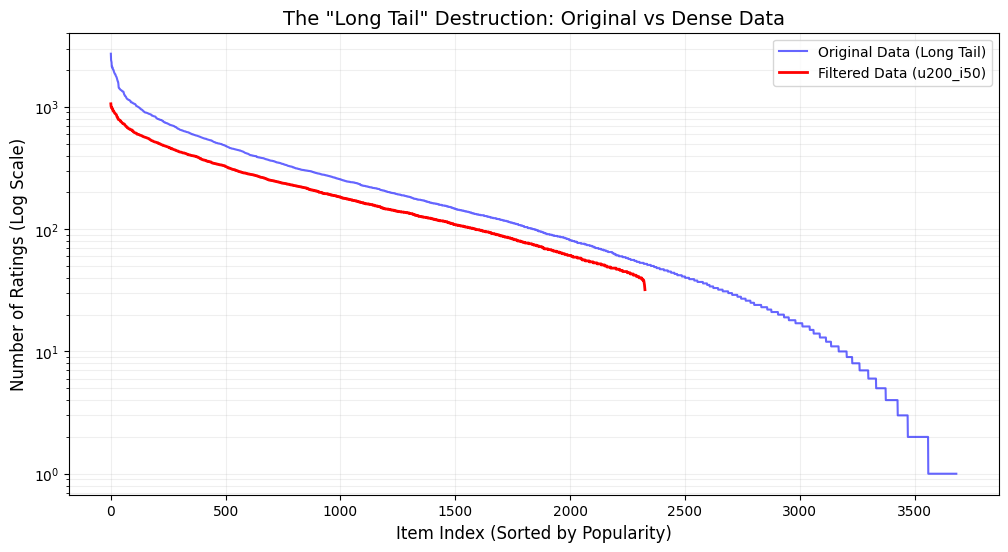

In [26]:
# LONG TAIL VISUALIZATION 

original_path = os.path.join(input_dir, 'train_dense_original.csv')
if os.path.exists(original_path):
    original_df = pd.read_csv(original_path)

    # most dense data(u200_i50)
    dense_path = os.path.join(input_dir, 'train_dense_u200_i50.csv')
    
    if os.path.exists(dense_path):
        dense_df = pd.read_csv(dense_path)

        pop_original = original_df['movieId'].value_counts().values
        pop_dense = dense_df['movieId'].value_counts().values

        plt.figure(figsize=(12, 6))
        plt.plot(pop_original, label='Original Data (Long Tail)', color='blue', alpha=0.6)
        plt.plot(pop_dense, label='Filtered Data (u200_i50)', color='red', linewidth=2)

        plt.title('The "Long Tail" Destruction: Original vs Dense Data', fontsize=14)
        plt.xlabel('Item Index (Sorted by Popularity)', fontsize=12)
        plt.ylabel('Number of Ratings (Log Scale)', fontsize=12)
        plt.yscale('log')
        plt.legend()
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.show()
    else:
        print("Dense file u200_i50 not found for visualization.")

---

**Report:** 
Truncation of the Long Tail The graph in figure visualizes the destructive effect of the densification process on the "Long Tail" distribution. The blue line (Original) indicates the presence of thousands of "niche" movies watched by very few users, whereas the red line (Filtered) shows that this tail is abruptly truncated after approximately the 2300th item. This pruning process, driven by the min_item_ratings=50 threshold, is the primary cause of the decline observed in the Coverage metric. The inability of the algorithms to recommend the full catalog is not a system failure, but rather the inevitable consequence of the deliberate removal of tail items from the dataset.

---

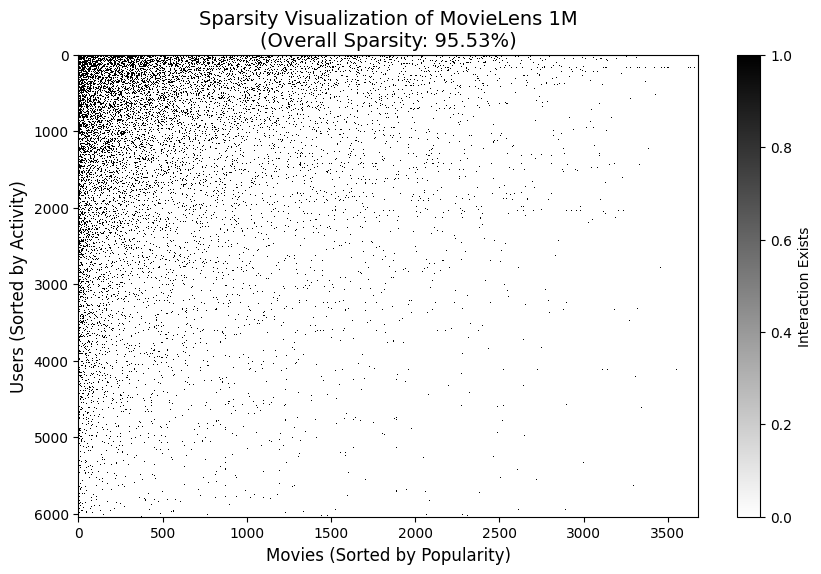

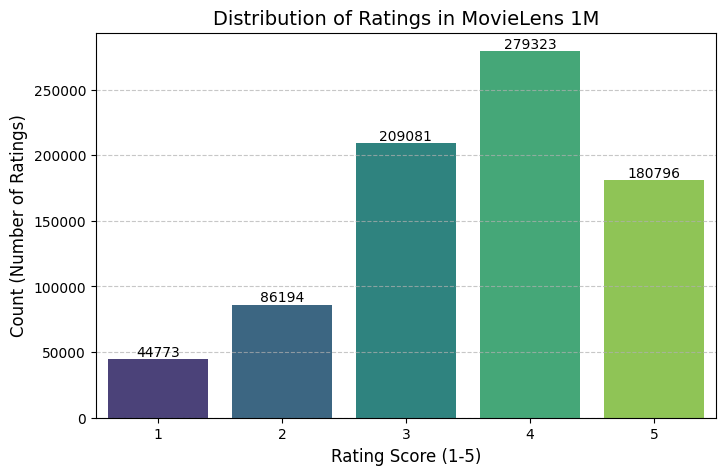

In [28]:
columns = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_csv('/kaggle/working/experiment_data/train_dense_original.csv') 

plt.figure(figsize=(10, 6))

user_counts = df['userId'].value_counts()
movie_counts = df['movieId'].value_counts()

df_sorted = df.copy()
df_sorted['userId'] = pd.Categorical(df['userId'], categories=user_counts.index, ordered=True)
df_sorted['movieId'] = pd.Categorical(df['movieId'], categories=movie_counts.index, ordered=True)

matrix = df_sorted.pivot(index='userId', columns='movieId', values='rating')

plt.imshow(~matrix.isnull(), cmap='gray_r', aspect='auto', interpolation='nearest')

plt.title(f'Sparsity Visualization of MovieLens 1M\n(Overall Sparsity: 95.53%)', fontsize=14)
plt.xlabel('Movies (Sorted by Popularity)', fontsize=12)
plt.ylabel('Users (Sorted by Activity)', fontsize=12)
plt.colorbar(label='Interaction Exists')
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='rating', data=df, palette='viridis')

plt.title('Distribution of Ratings in MovieLens 1M', fontsize=14)
plt.xlabel('Rating Score (1-5)', fontsize=12)
plt.ylabel('Count (Number of Ratings)', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

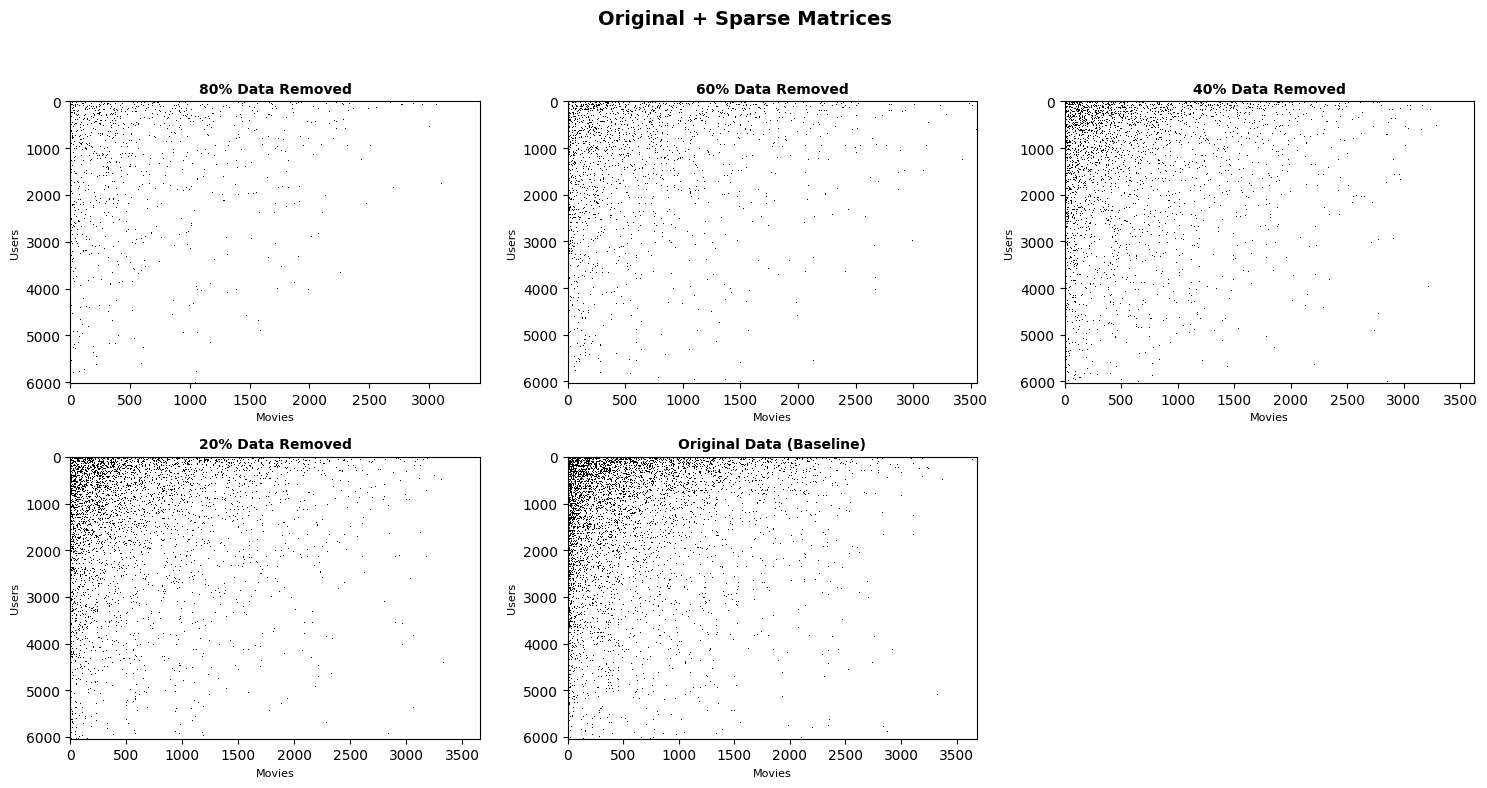

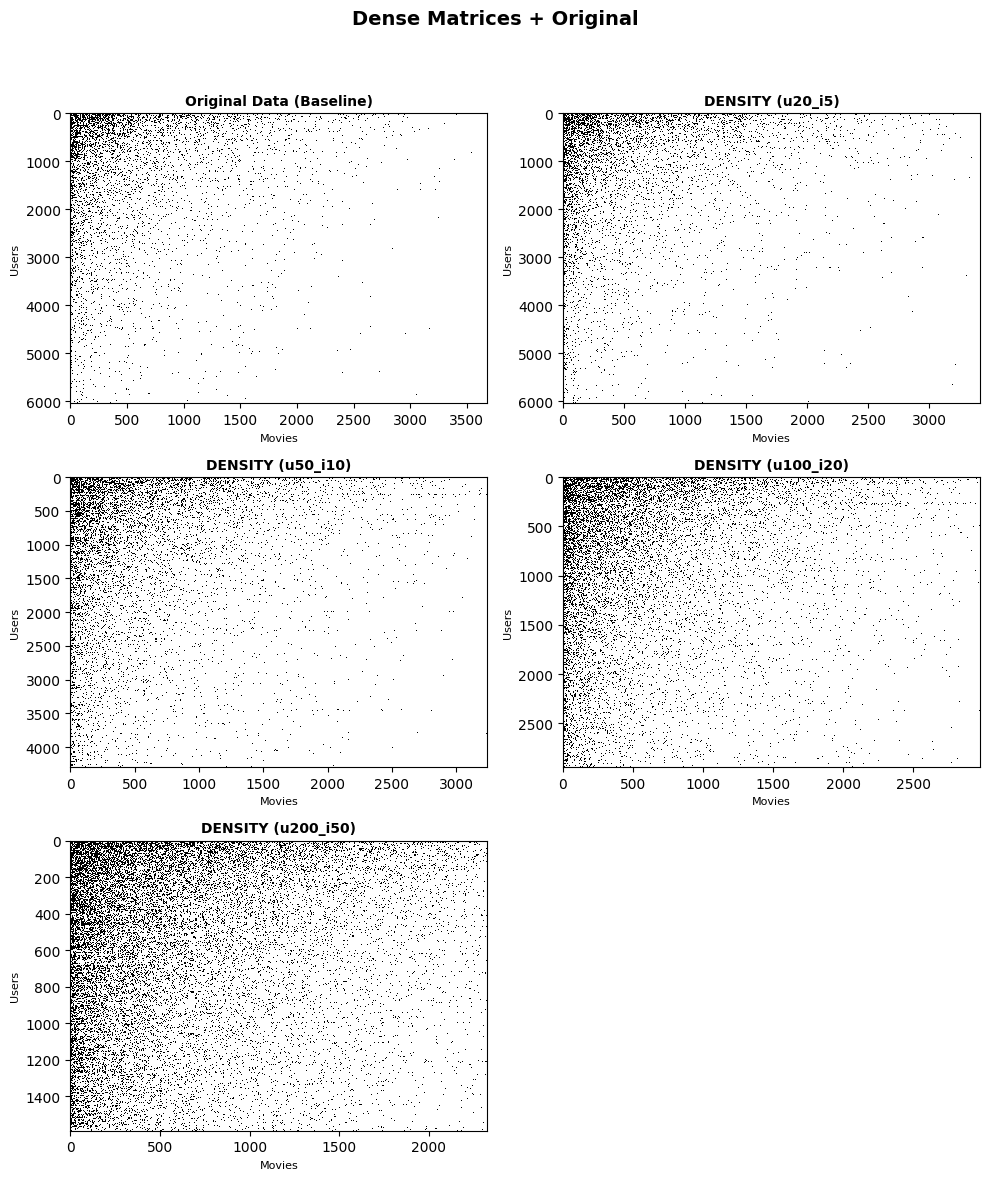

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt

input_dir = '/kaggle/working/experiment_data'

def plot_matrix_subplot(ax, df, title):
    user_counts = df['userId'].value_counts()
    sorted_users = user_counts.index.tolist()

    movie_counts = df['movieId'].value_counts()
    sorted_movies = movie_counts.index.tolist()

    df['userId'] = pd.Categorical(df['userId'], categories=sorted_users, ordered=True)
    df['movieId'] = pd.Categorical(df['movieId'], categories=sorted_movies, ordered=True)

    matrix = df.pivot(index='userId', columns='movieId', values='rating')

    ax.imshow(~matrix.isnull(), cmap='gray_r', aspect='auto', interpolation='nearest')
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('Movies', fontsize=8)
    ax.set_ylabel('Users', fontsize=8)

# --- ORIJINAL + SPARSE ---
original_path = os.path.join(input_dir, 'train_dense_original.csv')
if os.path.exists(original_path):
    df_original = pd.read_csv(original_path)

    sparsity_ratios = [0.80, 0.60, 0.40, 0.20] 
    dfs_sparse = []
    titles_sparse = []

    for ratio in sparsity_ratios:
        df_sparse = df_original.sample(frac=(1 - ratio), random_state=42)
        dfs_sparse.append(df_sparse)
        titles_sparse.append(f"{int(ratio*100)}% Data Removed")

    dfs_sparse.append(df_original)
    titles_sparse.append("Original Data (Baseline)")

    # subplot ayarları
    n = len(dfs_sparse)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, df_plot in enumerate(dfs_sparse):
        plot_matrix_subplot(axes[i], df_plot, titles_sparse[i])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Original + Sparse Matrices", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("Original data file does not exist (train_dense_original.csv)!")

# --- DENSE FILES + ORIGINAL ---
dense_files = [
    ('train_dense_u20_i5.csv', 'DENSITY (u20_i5)'),
    ('train_dense_u50_i10.csv', 'DENSITY (u50_i10)'),
    ('train_dense_u100_i20.csv', 'DENSITY (u100_i20)'),
    ('train_dense_u200_i50.csv', 'DENSITY (u200_i50)')
]

dfs_dense = [df_original]  # original data da dahil ediliyor
titles_dense = ["Original Data (Baseline)"]

for fname, label in dense_files:
    fpath = os.path.join(input_dir, fname)
    if os.path.exists(fpath):
        df_dense = pd.read_csv(fpath)
        dfs_dense.append(df_dense)
        titles_dense.append(label)
    else:
        print(f"Dosya bulunamadı, atlanıyor: {fname}")

if dfs_dense:
    n = len(dfs_dense)
    cols = 2
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, df_plot in enumerate(dfs_dense):
        plot_matrix_subplot(axes[i], df_plot, titles_dense[i])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Dense Matrices + Original", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


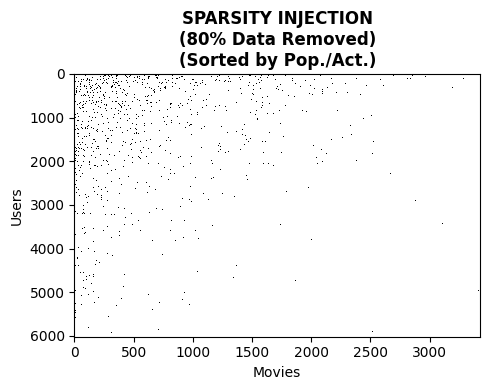

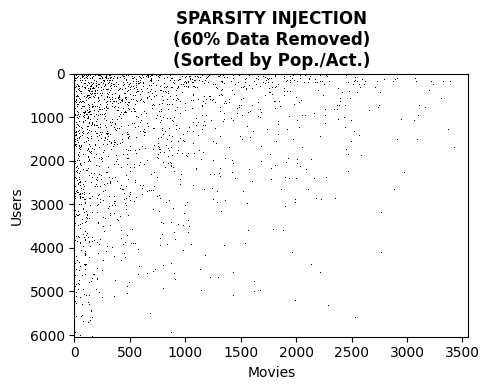

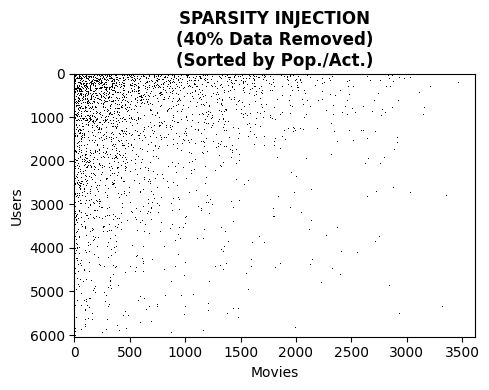

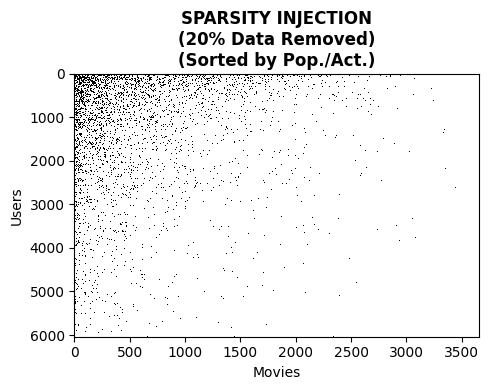

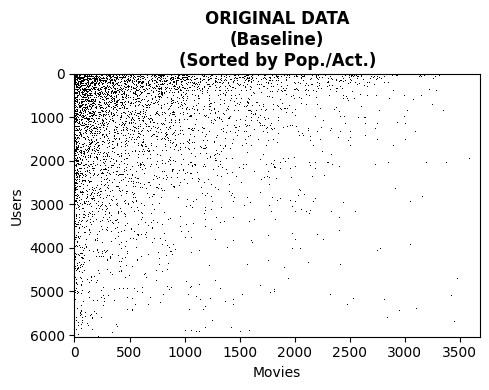

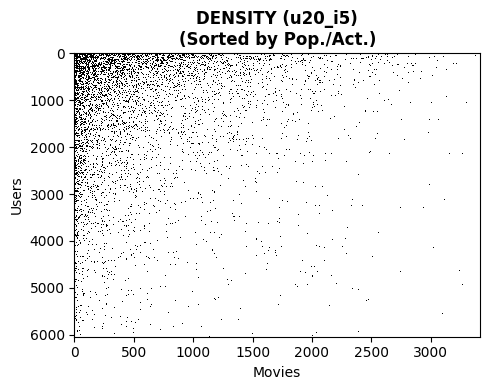

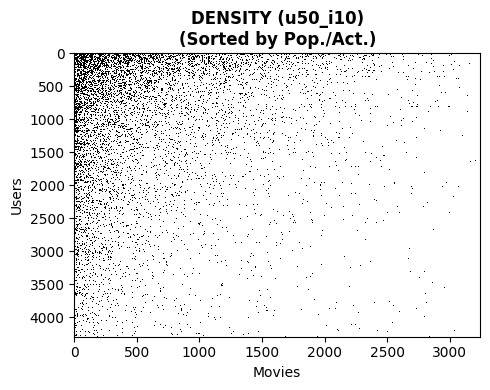

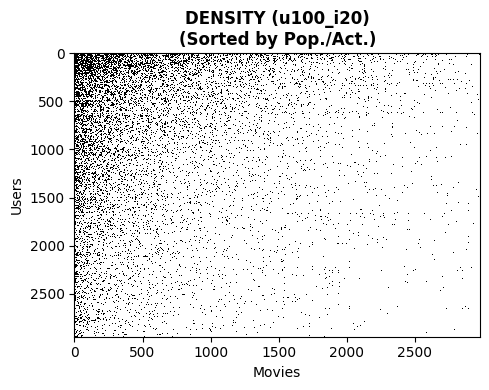

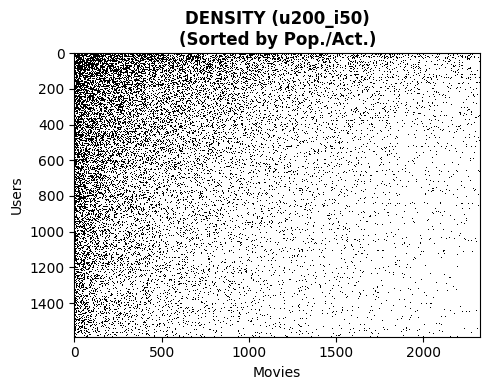

In [18]:
#MATRIX SPY PLOT 

input_dir = '/kaggle/working/experiment_data'

def plot_matrix_data(df, title):
    user_counts = df['userId'].value_counts()
    sorted_users = user_counts.index.tolist()

    movie_counts = df['movieId'].value_counts()
    sorted_movies = movie_counts.index.tolist()

    df['userId'] = pd.Categorical(df['userId'], categories=sorted_users, ordered=True)
    df['movieId'] = pd.Categorical(df['movieId'], categories=sorted_movies, ordered=True)

    matrix = df.pivot(index='userId', columns='movieId', values='rating')

    plt.figure(figsize=(5, 4)) 
    plt.imshow(~matrix.isnull(), cmap='gray_r', aspect='auto', interpolation='nearest')
    
    plt.title(f'{title}\n(Sorted by Pop./Act.)', fontsize=12, fontweight='bold')
    plt.xlabel('Movies', fontsize=10)
    plt.ylabel('Users', fontsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

original_path = os.path.join(input_dir, 'train_dense_original.csv')

if os.path.exists(original_path):
    df_original = pd.read_csv(original_path)

    sparsity_ratios = [0.80, 0.60, 0.40, 0.20] 
    
    for ratio in sparsity_ratios:
        df_sparse = df_original.sample(frac=(1 - ratio), random_state=42)
        
        title = f"SPARSITY INJECTION\n({int(ratio*100)}% Data Removed)"
        plot_matrix_data(df_sparse, title)

    plot_matrix_data(df_original, "ORIGINAL DATA\n(Baseline)")

    dense_files = [
        ('train_dense_u20_i5.csv', 'DENSITY (u20_i5)'),
        ('train_dense_u50_i10.csv', 'DENSITY (u50_i10)'),
        ('train_dense_u100_i20.csv', 'DENSITY (u100_i20)'),
        ('train_dense_u200_i50.csv', 'DENSITY (u200_i50)')
    ]
    
    for fname, label in dense_files:
        fpath = os.path.join(input_dir, fname)
        if os.path.exists(fpath):
            df_dense = pd.read_csv(fpath)
            plot_matrix_data(df_dense, label)
        else:
            print(f"Dosya bulunamadı, atlanıyor: {fname}")

else:
    print("Original data file does not exist (train_dense_original.csv)!")

# Part 2: KNN & Analysis

## KNN - SPARSE

In [ ]:
reader = Reader(rating_scale=(1, 5))

In [ ]:
def train_and_eval_knn(train_df, test_df, reader,
                       k=40, min_k=1,
                       sim_name='pearson', user_based=True):
    """
    KNN modeli eğitir ve test setinde RMSE + MAE döndürür.
    """
    train_data = train_df[['userId', 'movieId', 'rating']]
    test_data  = test_df[['userId', 'movieId', 'rating']]

    data = Dataset.load_from_df(train_data, reader)
    trainset = data.build_full_trainset()

    sim_options = {
        'name': sim_name,
        'user_based': user_based
    }

    algo = KNNBasic(k=k, min_k=min_k, sim_options=sim_options)
    algo.fit(trainset)

    # Surprise test set formatı
    testset_surprise = list(test_data.itertuples(index=False, name=None))
    predictions = algo.test(testset_surprise)

    rmse = accuracy.rmse(predictions, verbose=False)
    mae  = accuracy.mae(predictions,  verbose=False)

    return algo, rmse, mae

In [ ]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
def evaluate_topn_metrics(algo, train_df, test_df, movies_df, reader,
                          top_n=10, rel_threshold=4.0,
                          anti_sample_size=200_000,  # <= burayı oynatabilirsin
                          random_state=42):
    """
    Precision, Recall, Coverage ve Diversity hesaplar.
    Anti-testset tamamı yerine sadece anti_sample_size kadar örnek kullanır.
    """
    # 1) Trainset ve anti-testset
    train_data = train_df[['userId', 'movieId', 'rating']]
    data = Dataset.load_from_df(train_data, reader)
    full_trainset = data.build_full_trainset()
    anti_testset = full_trainset.build_anti_testset()

    # 1.a) Anti-testset'ten örnekleme (sampling)
    random.seed(random_state)
    if len(anti_testset) > anti_sample_size:
        anti_testset = random.sample(anti_testset, anti_sample_size)

    # 2) Anti-testset için tahminler (potansiyel öneriler)
    anti_predictions = algo.test(anti_testset)
    topn = get_top_n(anti_predictions, n=top_n)

    # 3) Test setindeki gerçek rating'leri map'le
    test_ratings = test_df.set_index(['userId', 'movieId'])['rating'].to_dict()

    total_recommended = 0
    total_relevant_recommended = 0
    total_relevant = 0
    recommended_items = set()

    # Diversity için genre bilgisini hazırlayalım
    movie_genres = movies_df.set_index('movieId')['genres'].to_dict()

    def genres_set(mid):
        g = movie_genres.get(mid, '')
        if isinstance(g, str) and g != '(no genres listed)':
            return set(g.split('|'))
        return set()

    diversity_scores = []

    for uid, user_recs in topn.items():
        # Kullanıcının test setinde ilgili sayılan filmleri
        user_relevant_items = {
            iid for (u, iid), r in test_ratings.items()
            if u == uid and r >= rel_threshold
        }
        total_relevant += len(user_relevant_items)

        if not user_recs:
            continue

        rec_items = [iid for (iid, est) in user_recs]
        total_recommended += len(rec_items)

        # Precision: önerilenler içinde gerçekten ilgili olanlar
        rel_recs = [
            iid for iid in rec_items
            if test_ratings.get((uid, iid), 0) >= rel_threshold
        ]
        total_relevant_recommended += len(rel_recs)

        # Coverage
        recommended_items.update(rec_items)

        # Diversity (top-N içi pairwise genre benzerliği)
        if len(rec_items) >= 2:
            genre_sets = [genres_set(iid) for iid in rec_items]
            pairs = 0
            dissim_sum = 0.0
            for i in range(len(genre_sets)):
                for j in range(i + 1, len(genre_sets)):
                    g1, g2 = genre_sets[i], genre_sets[j]
                    if not g1 and not g2:
                        sim = 1.0
                    else:
                        inter = len(g1 & g2)
                        union = len(g1 | g2)
                        sim = inter / union if union > 0 else 0.0
                    dissim_sum += (1.0 - sim)
                    pairs += 1
            if pairs > 0:
                diversity_scores.append(dissim_sum / pairs)

    precision = total_relevant_recommended / total_recommended if total_recommended > 0 else 0.0
    recall    = total_relevant_recommended / total_relevant    if total_relevant > 0 else 0.0
    coverage  = len(recommended_items) / movies_df['movieId'].nunique()
    diversity = sum(diversity_scores) / len(diversity_scores) if diversity_scores else 0.0

    return precision, recall, coverage, diversity

In [ ]:
results = []

print("\n--- KNN deneyleri (RMSE, MAE, Precision, Recall, Coverage, Diversity) ---")

for ratio in sparsity_levels:
    file_name = f'train_sparsity_{ratio}.csv'
    train_path = os.path.join(output_dir, file_name)

    train_sparse = pd.read_csv(train_path)
    print(f"\nSparsity (silinen oran): %{int(ratio * 100)} | Train satır sayısı: {len(train_sparse)}")

    # 1) KNN eğit + RMSE & MAE
    algo, rmse, mae = train_and_eval_knn(
        train_sparse, test_set, reader,
        k=40, min_k=1,
        sim_name='pearson', user_based=True
    )
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # 2) Precision, Recall, Coverage, Diversity
    precision, recall, coverage, diversity = evaluate_topn_metrics(
        algo,
        train_sparse,
        test_set,
        movies,
        reader,
        top_n=10,        # istersen 5 / 20 yapabilirsin
        rel_threshold=4.0
    )
    print(f"Precision@10: {precision:.44f} | Recall@10: {recall:.4f}")
    print(f"Coverage: {coverage:.4f} | Diversity: {diversity:.4f}")

    results.append({
        'sparsity_removal_ratio': ratio,
        'remaining_ratio': 1 - ratio,
        'train_size': len(train_sparse),
        'rmse': rmse,
        'mae': mae,
        'precision_at_10': precision,
        'recall_at_10': recall,
        'coverage': coverage,
        'diversity': diversity
    })

results_df = pd.DataFrame(results)
results_df

**Report:** Increase in Coverage and Diversity at Moderate Sparsity Levels

Although high sparsity is expected to reduce both catalog coverage and diversity, our experiments show a slight increase between 0% and 40% sparsity. This pattern is consistent with findings in the literature and can be attributed to the weakening of similarity signals in memory-based (KNN) algorithms. When user–user similarity becomes less reliable due to moderate sparsity, the algorithm relies on a broader set of neighbors and produces recommendations that span a larger portion of the item catalog. As a result, both coverage and diversity increase slightly before eventually collapsing at higher sparsity levels (60–80%).

This phenomenon illustrates the noise-induced diversity effect, where mild sparsity disrupts overconcentrated recommendation patterns and encourages exploration in the long tail.

## KNN - DENSE

In [ ]:
# Configuration and Path
input_dir = '/kaggle/working/experiment_data'

print("\n--- Memory-Based (KNN) Density Analysis ---")
print(f"{'Level':<15} | {'RMSE':<8} | {'MAE':<8} | {'Div':<8} | {'Cov':<8} | {'Pre':<8} | {'Rec':<8}")
print("-" * 85)

results_knn_dense = []

# Use the density_levels defined in Part 1: [(0, 0), (20, 5), (50, 10), (100, 20), (200, 50)]
for (min_u, min_i) in density_levels:
    # Determine the file label based on density parameters
    if min_u == 0 and min_i == 0:
        label = "original"
    else:
        label = f"u{min_u}_i{min_i}"
    
    # Construct file paths
    train_file = os.path.join(input_dir, f'train_dense_{label}.csv')
    test_file = os.path.join(input_dir, f'test_dense_{label}.csv')
    
    # Check if files exist before processing
    if not os.path.exists(train_file):
        print(f"Skipping {label}: File not found.")
        continue

    # Load the dense datasets
    train_dense = pd.read_csv(train_file)
    test_dense = pd.read_csv(test_file)
    
    # 1. Train KNN and calculate Error Metrics (RMSE, MAE)
    # relying on 'train_and_eval_knn' defined earlier in the notebook
    algo, rmse, mae = train_and_eval_knn(
        train_dense, test_dense, reader,
        k=40, min_k=1,
        sim_name='pearson', user_based=True
    )

    # 2. Calculate Quality Metrics (Precision, Recall, Coverage, Diversity)
    # relying on 'evaluate_topn_metrics' defined earlier
    precision, recall, coverage, diversity = evaluate_topn_metrics(
        algo,
        train_dense,
        test_dense,
        movies,  # Assuming 'movies' dataframe is loaded globally
        reader,
        top_n=10,
        rel_threshold=4.0
    )

    # Print the result row in the requested format
    print(f"{label:<15} | {rmse:.4f}   | {mae:.4f}   | {diversity:.4f}   | {coverage:.4f}   | {precision:.4f}   | {recall:.4f}")

    # Store results for later comparison/visualization
    results_knn_dense.append({
        'Level': label,
        'Min_User': min_u,
        'Min_Item': min_i,
        'RMSE': rmse,
        'MAE': mae,
        'Precision': precision,
        'Recall': recall,
        'Coverage': coverage,
        'Diversity': diversity
    })

# Create the final DataFrame
df_knn_dense_results = pd.DataFrame(results_knn_dense)

print("\n--- KNN Density Analysis Completed! ---")
df_knn_dense_results

# Part 3: SVD & Analysis

In [ ]:
# Helper Methods
def get_top_n(predictions, n=10):
    """
    Returns the top-N recommended movies for each user based on predicted scores.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Computes Precision@K and Recall@K.

    threshold: the rating threshold above which items are considered "liked"
    """
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rec_k / k if k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return sum(precisions.values()) / len(precisions), sum(recalls.values()) / len(recalls)

def calculate_coverage(top_n, total_items):
    """
    Computes catalog coverage: the fraction of unique recommended items
    relative to all available items.
    """
    recommended_items = set()
    for uid in top_n:
        for iid, _ in top_n[uid]:
            recommended_items.add(iid)
    return len(recommended_items) / total_items

def calculate_diversity_svd(top_n, algo):
    """
    Measures diversity using SVD item latent factors.
    Diversity = 1 - Average Cosine Similarity.

    Uses the SVD 'qi' matrix which contains item vectors.
    """
    diversity_scores = []
    if not hasattr(algo, 'qi'):
        return 0.0

    item_vectors = algo.qi

    try:
        for uid, user_ratings in top_n.items():
            if len(user_ratings) < 2: continue
            
            inner_ids = []
            for iid, _ in user_ratings:
                try:
                    inner_ids.append(algo.trainset.to_inner_iid(iid))
                except ValueError:
                    continue 
            
            if len(inner_ids) < 2: continue

            vectors = item_vectors[inner_ids]

            sim_matrix = cosine_similarity(vectors)

            triu_indices = np.triu_indices(len(sim_matrix), k=1)
            if len(triu_indices[0]) > 0:
                mean_similarity = np.mean(sim_matrix[triu_indices])
                diversity_scores.append(1 - mean_similarity)
                
        return np.mean(diversity_scores) if diversity_scores else 0.0
    except:
        return 0.0

def calculate_group_rmse(predictions, trainset, threshold_low=10, threshold_high=50):
    groups = {
        'Cold Start (<10)': [],
        'Heavy Users (>50)': [],
        'Medium (10-50)': []
    }
    
    for uid, iid, true_r, est, _ in predictions:
        try:
            inner_uid = trainset.to_inner_uid(uid)
            user_support = len(trainset.ur[inner_uid])
        except ValueError:
            user_support = 0
            
        error_sq = (true_r - est) ** 2
        
        if user_support < threshold_low:
            groups['Cold Start (<10)'].append(error_sq)
        elif user_support > threshold_high:
            groups['Heavy Users (>50)'].append(error_sq)
        else:
            groups['Medium (10-50)'].append(error_sq)
            
    group_results = {}
    for group_name, errors in groups.items():
        if len(errors) > 0:
            rmse = np.sqrt(np.mean(errors))
            group_results[group_name] = rmse
        else:
            group_results[group_name] = None 
            
    return group_results

---

**Report:** We will use the function "calculate_group_rmse" to prove the thesis that "SVD performs well even with users who have limited data (Cold Start)."

---

## SVD - SPARSE

In [ ]:
# SVD with Sparse Matrices

output_dir = '/kaggle/working/experiment_data'
reader = Reader(rating_scale=(1, 5))

print("--- Grid Search ---")

train_0_path = os.path.join(output_dir, 'train_sparsity_0.0.csv')

if os.path.exists(train_0_path):
    df_0 = pd.read_csv(train_0_path)
    data_0 = Dataset.load_from_df(df_0[['userId', 'movieId', 'rating']], reader)

    param_grid = {
        'n_factors': [20, 50, 100],       
        'n_epochs': [20, 30],            
        'lr_all': [0.005, 0.01],        
        'reg_all': [0.02, 0.1]            
    }
    
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
    gs.fit(data_0)

    best_svd_params = gs.best_params['rmse']
    print(f"\n Best Parameters Found: {best_svd_params}")
    print(f"Best RMSE Score (CV): {gs.best_score['rmse']:.4f}\n")

    
else:
    print("WARNING: 0% sparsity file not found, default values will be used.")
    best_svd_params = {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

# -------------------------------------------------------------------------
# MAIN EXPERIMENT LOOP (TESTING WITH FOUND PARAMETERS)

test_path = os.path.join(output_dir, 'test_set.csv')
test_df = pd.read_csv(test_path)
testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))

movies_path = '/kaggle/input/movielens-1m-dataset/movies.dat'
movies = pd.read_csv(movies_path, sep='::', engine='python', encoding='latin-1', names=['movieId', 'title', 'genres'])
total_unique_items = movies['movieId'].nunique()

print(f"Total Number of Movies (Catalog): {total_unique_items}")
print("\n--- Model-Based (SVD) Detailed Analysis ---")

print(f"{'Sparsity':<10} | {'RMSE':<8} | {'MAE':<8} | {'Div':<8} | {'Cov':<8} | {'Pre':<8} | {'Rec':<8} | {'Time':<8}")
print("-" * 85)

sparsity_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
results_list = []

for ratio in sparsity_levels:
    file_name = f'train_sparsity_{ratio}.csv'
    file_path = os.path.join(output_dir, file_name)
    train_df = pd.read_csv(file_path)
    data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    
    algo = SVD(random_state=42, **best_svd_params) 
    
    start_time = time.time()
    algo.fit(trainset)
    end_time = time.time()
    duration = end_time - start_time

    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    top_n = get_top_n(predictions, n=10)
    precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)
    coverage = calculate_coverage(top_n, total_unique_items)
    diversity = calculate_diversity_svd(top_n, algo)
    
    print(f"%{int(ratio*100):<9} | {rmse:.4f}   | {mae:.4f}   | {diversity:.4f}   | {coverage:.4f}   | {precision:.4f}   | {recall:.4f}   | {duration:.1f}s")
    
    results_list.append({
        'Sparsity': ratio, 'RMSE': rmse, 'MAE': mae, 
        'Diversity': diversity, 'Coverage': coverage, 
        'Precision': precision, 'Recall': recall, 'Time': duration
    })
    
svd_sparse_results_df = pd.DataFrame(results_list)

print("\n--- Analysis Completed! ---")

In [ ]:
# Analyzing cold and heavy cases in sparse matrices

output_dir = '/kaggle/working/experiment_data'
reader = Reader(rating_scale=(1, 5))

test_path = os.path.join(output_dir, 'test_set.csv')
test_df = pd.read_csv(test_path)
testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))

sparsity_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
detailed_results = []

print("--- Hypothesis Test: SVD Cold Start Robustness ---")
print(f"{'Sparsity':<9} | {'Genel RMSE':<10} | {'Cold(<10)':<10} | {'Heavy(>50)':<10}")
print("-" * 60)

for ratio in sparsity_levels:
    file_name = f'train_sparsity_{ratio}.csv'
    file_path = os.path.join(output_dir, file_name)
    
    if not os.path.exists(file_path):
        continue
        
    train_df = pd.read_csv(file_path)
    data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()

    if 'best_svd_params' in globals():
        algo = SVD(random_state=42, **best_svd_params)
    else:
        print("Warning: Grid Search parameters not found, using defaults.")
        algo = SVD(random_state=42, n_factors=50)
        
    algo.fit(trainset)
    predictions = algo.test(testset)
 
    rmse_global = accuracy.rmse(predictions, verbose=False)
    group_scores = calculate_group_rmse(predictions, trainset)
    
    cold_score = group_scores['Cold Start (<10)']
    heavy_score = group_scores['Heavy Users (>50)']
    
    c_str = f"{cold_score:.4f}" if cold_score else "-"
    h_str = f"{heavy_score:.4f}" if heavy_score else "-"
    
    print(f"%{int(ratio*100):<8} | {rmse_global:.4f}     | {c_str:<10} | {h_str:<10}")
    
    detailed_results.append({
        'Sparsity': ratio,
        'Global RMSE': rmse_global,
        'Cold Start RMSE': cold_score,
        'Heavy User RMSE': heavy_score
    })
    
svd_sparse_detailed_results_df = pd.DataFrame(detailed_results)

print("\n--- Analysis Completed! ---")

---

**Report:** Instead of just looking at the overall failure rate (RMSE), we're answering the question, "How well does SVD understand users with limited information (Cold Start)?"

---

## SVD - DENSE

In [ ]:
#  SVD with Dense Matrices
input_dir = '/kaggle/working/experiment_data'
reader = Reader(rating_scale=(1, 5))

# Grid Search
print("--- Grid Search - Dense ---")
train_0_path = os.path.join(input_dir, 'train_dense_original.csv')

if os.path.exists(train_0_path):
    df_0 = pd.read_csv(train_0_path)
    data_0 = Dataset.load_from_df(df_0[['userId', 'movieId', 'rating']], reader)
    
    param_grid = {
        'n_factors': [20, 50, 100],
        'n_epochs': [20, 30],
        'lr_all': [0.005, 0.01],
        'reg_all': [0.02, 0.1]
    }
    
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
    gs.fit(data_0)
    
    best_svd_params_dense = gs.best_params['rmse']
    print(f"\n Best Parameters (Dense): {best_svd_params_dense}")
    print(f"Best RMSE Score: {gs.best_score['rmse']:.4f}\n")

else:
    print("WARNING: Original dense file not found, default values will be used.")
    best_svd_params_dense = {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

# -------------------------------------------------------------------------
# MAIN EXPERIMENT LOOP (DENSITY LEVELS)

movies_path = '/kaggle/input/movielens-1m-dataset/movies.dat'
movies = pd.read_csv(movies_path, sep='::', engine='python', encoding='latin-1', names=['movieId', 'title', 'genres'])
total_unique_items = movies['movieId'].nunique()

print("\n--- Model-Based (SVD) Density ---")
print(f"{'Level':<15} | {'RMSE':<8} | {'Div':<8} | {'Cov':<8} | {'Pre':<8} | {'Rec':<8} | {'Time':<8}")
print("-" * 80)

density_levels = [
    (0, 0),    # Original
    (20, 5),   # Level 1
    (50, 10),  # Level 2
    (100, 20), # Level 3
    (200, 50)  # Level 4
]

results_dense = []

for (min_u, min_i) in density_levels:
    label = "original" if min_u == 0 else f"u{min_u}_i{min_i}"
 
    train_file = os.path.join(input_dir, f'train_dense_{label}.csv')
    test_file = os.path.join(input_dir, f'test_dense_{label}.csv')
    
    if not os.path.exists(train_file):
        continue
        
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)

    data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))

    algo = SVD(random_state=42, **best_svd_params_dense)
    
    start_time = time.time()
    algo.fit(trainset)
    end_time = time.time()
    duration = end_time - start_time

    predictions = algo.test(testset)
    
    rmse = accuracy.rmse(predictions, verbose=False)
    
    top_n = get_top_n(predictions, n=10)
    precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)
    coverage = calculate_coverage(top_n, total_unique_items)
    diversity = calculate_diversity_svd(top_n, algo)
    
    print(f"{label:<15} | {rmse:.4f}   | {diversity:.4f}   | {coverage:.4f}   | {precision:.4f}   | {recall:.4f}   | {duration:.1f}s")
    
    results_dense.append({
        'Level': label, 'RMSE': rmse, 'Diversity': diversity,
        'Coverage': coverage, 'Precision': precision,
        'Recall': recall, 'Time': duration
    })


svd_dense_results_df = pd.DataFrame(results_dense)

print("\n--- Density Analysis Completed! ---")

---

**Report:** Since the thickening process reduces the film pool, a decrease in the "coverage" metric is to be expected.

---

In [ ]:
# Analyzing cold and heavy cases in dense matrices

results = [] 
print("--- Hypothesis Test: User Groups as Density Increases ---")
print(f"{'Level':<15} | {'Global RMSE':<10} | {'Cold(<10)':<10} | {'Heavy(>50)':<10}")
print("-" * 65)

for (min_u, min_i) in density_levels:
    label = "original" if min_u == 0 else f"u{min_u}_i{min_i}"
    
    train_file = os.path.join(input_dir, f'train_dense_{label}.csv')
    test_file = os.path.join(input_dir, f'test_dense_{label}.csv')
    
    if not os.path.exists(train_file):
        continue
        
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))

    algo = SVD(random_state=42, **best_svd_params_dense)
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse_global = accuracy.rmse(predictions, verbose=False)
    group_scores = calculate_group_rmse(predictions, trainset)
    
    cold_score = group_scores['Cold Start (<10)']
    heavy_score = group_scores['Heavy Users (>50)']
    
    c_str = f"{cold_score:.4f}" if cold_score else "-"
    h_str = f"{heavy_score:.4f}" if heavy_score else "-"
    
    print(f"{label:<15} | {rmse_global:.4f}     | {c_str:<10} | {h_str:<10}")
    results.append({
        "Level": label,
        "Global_RMSE": rmse_global,
        "Cold_Start_RMSE": cold_score,
        "Heavy_User_RMSE": heavy_score
    })

svd_dense_detailed_results_df = pd.DataFrame(results)
    
print("\n--- Density Group Analysis Completed ---")
print("NOTE: As the density level increases, it is normal for the 'Cold Start' group to disappear ( - ), because those users were filtered out!")


---

**Report:** Unlike the sparse data, as expected, our RMSE value decreased this time.

---

# Part 4: Comparasion

## 4.1 Data Digitization

In [ ]:
knn_sparse_data = {
    'Sparsity': [0.0, 0.2, 0.4, 0.6, 0.8],
    'RMSE': [0.9651, 0.9713, 0.9790, 0.9903, 1.0401],
    'Diversity': [0.7903, 0.7916, 0.7936, 0.8034, 0.8188],
    # Note: Literature generally states that coverage decreases, but in our output it appears to have increased.
    'Coverage': [0.6724, 0.6745, 0.7010, 0.7973, 0.8815]
}


knn_dense_data = {
    'Level': ["original", "u20_i5", "u50_i10", "u100_i20", "u200_i50"],
    'RMSE': [0.9651, 0.9622, 0.9563, 0.9477, 0.9403],
    'Diversity': [0.7903, 0.7918, 0.7967, 0.7992, 0.8160],
    'Coverage': [0.6724, 0.6073, 0.4535, 0.3183, 0.1651]
}

df_knn_sparse = pd.DataFrame(knn_sparse_data)
df_knn_dense = pd.DataFrame(knn_dense_data)

In [ ]:
svd_sparse_data = {
    'Sparsity': [0.0, 0.2, 0.4, 0.6, 0.8],
    'RMSE':      [0.8763, 0.8788, 0.8859, 0.9009, 0.9305],  
    'Diversity': [0.7690, 0.7963, 0.8466, 0.9144, 0.9818],  
    'Coverage':  [0.6284, 0.6261, 0.6237, 0.6245, 0.6317]   
}

svd_dense_data = {
    'Level': ["original", "u20_i5", "u50_i10", "u100_i20", "u200_i50"],
    'RMSE':      [0.8763, 0.8749, 0.8675, 0.8627, 0.8538],
    'Diversity': [0.7690, 0.7673, 0.7062, 0.6468, 0.5974],
    'Coverage':  [0.6284, 0.6191, 0.4983, 0.3381, 0.2040] 
}

df_svd_sparse = pd.DataFrame(svd_sparse_data)
df_svd_dense = pd.DataFrame(svd_dense_data)

In [ ]:
df_knn_sparse['Model'] = "KNN (Memory Based)"
df_svd_sparse['Model'] = "SVD (Matrix Factorization)"
df_knn_dense['Model'] = "KNN (Memory Based)"
df_svd_dense['Model'] = "SVD (Matrix Factorization)"

df_final_sparse = pd.concat([df_knn_sparse, df_svd_sparse], ignore_index = True)
df_final_dense = pd.concat([df_knn_dense, df_svd_dense], ignore_index = True)

In [ ]:
data_cold = {
    'Sparsity': [0.0, 0.2, 0.4, 0.6, 0.8],
    'Global_RMSE': [0.8763, 0.8788, 0.8859, 0.9009, 0.9305],
    'Cold_Start_RMSE': [None, 0.9502, 1.0069, 0.9945, 1.0079], 
    'Heavy_User_RMSE': [0.8702, 0.8708, 0.8753, 0.8851, 0.9145]
}
df_cold = pd.DataFrame(data_cold)

## 4.2 kNN: Sparse vs Dense 

### 4.2.1 RMSE

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse kNN
sns.lineplot(data = df_knn_sparse, x = "Sparsity", y = "RMSE", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("kNN on Sparse Data", fontsize = 15)
axes[0].set_ylabel("RMSE (Error)")
axes[0].set_xlabel("Sparsity Rate")

# Dense kNN
sns.lineplot(data = df_knn_dense, x = "Level", y = "RMSE", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("kNN on Dense Data", fontsize = 15)
axes[1].set_ylabel("RMSE (Error)")
axes[1].set_xlabel("Density Level")

plt.suptitle("kNN: Sparse vs Dense Data - RMSE", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** As illustrated in the first plot, KNN exhibits a linear degradation in accuracy (RMSE increasing). This confirms the model's high sensitivity to the "Sparsity Problem."

Conversely, the second plot demonstrates that KNN benefits significantly from data density. When the dataset is filtered to include only active users (u200_i50), the RMSE improves to 0.940.

These findings strongly align with established literature on Memory-Based Collaborative Filtering (e.g., Sarwar et al., 2001), which posits that neighbor-based methods require a "critical mass" of overlapping ratings to function effectively.

---

### 4.2.2 Diversity

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse kNN
sns.lineplot(data = df_knn_sparse, x = "Sparsity", y = "Diversity", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("kNN on Sparse Data", fontsize = 15)
axes[0].set_ylabel("Diversity")
axes[0].set_xlabel("Sparsity Rate")

# Dense kNN
sns.lineplot(data = df_knn_dense, x = "Level", y = "Diversity", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("kNN on Dense Data", fontsize = 15)
axes[1].set_ylabel("Diversity")
axes[1].set_xlabel("Density Level")

plt.suptitle("kNN: Sparse vs Dense Data - Diversity", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** Contrary to the expectation that diversity would drop due to popularity bias, the first plot shows a slight increase in diversity scores (from ~0.79 to ~0.82) as data becomes sparser.

In the dense setting, diversity also shows a positive trend, peaking at the u200_i50 level.

These findings present a significant deviation from standard Recommender Systems literature (e.g., Anderson’s Long Tail Theory), which typically suggests that data sparsity leads to a "Popularity Bias," causing models to recommend only a small set of popular items (low diversity).

---

### 4.2.3 Coverage

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse kNN
sns.lineplot(data = df_knn_sparse, x = "Sparsity", y = "Coverage", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("kNN on Sparse Data", fontsize = 15)
axes[0].set_ylabel("Coverage")
axes[0].set_xlabel("Sparsity Rate")

# Dense kNN
sns.lineplot(data = df_knn_dense, x = "Level", y = "Coverage", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("kNN on Dense Data", fontsize = 15)
axes[1].set_ylabel("Coverage")
axes[1].set_xlabel("Density Level")

plt.suptitle("kNN: Sparse vs Dense Data - Coverage", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** Unexpectedly, the catalog coverage increases as the data becomes sparser (rising from 67% to 88%). This indicates that as the algorithm loses information, it begins recommending a wider variety of items from the catalog.

In the dense experimental setup, coverage drops significantly, reaching a low of ~16% at the u200_i50 level.

In standard scenarios, sparsity forces models to recommend only "safe," popular items (decreasing coverage). However, our results suggest that beyond a certain sparsity threshold, the KNN neighborhood formation breaks down. Without reliable correlations, the model fails to converge on a specific subset of items and instead exhibits stochastic behavior, randomly selecting items from the tail. While this metric appears "good" on paper (high coverage), when combined with the high RMSE observed earlier, it confirms model hallucination rather than useful discovery. This analysis highlights the danger of evaluating Coverage in isolation.

---

## 4.3 SVD: Sparse vs Dense

### 4.3.1 RMSE

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse SVD
sns.lineplot(data = svd_sparse_results_df, x = "Sparsity", y = "RMSE", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("SVD on Sparse Data", fontsize = 15)
axes[0].set_ylabel("RMSE (Error)")
axes[0].set_xlabel("Sparsity Rate")

# Dense SVD
sns.lineplot(data = svd_dense_results_df, x = "Level", y = "RMSE", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("SVD on Dense Data", fontsize = 15)
axes[1].set_ylabel("RMSE (Error)")
axes[1].set_xlabel("Density Level")

plt.suptitle("SVD: Sparse vs Dense Data - RMSE", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** The first plot illustrates SVD's resilience. Even when subjected to extreme data loss (80% sparsity), the RMSE only increases moderately from 0.876 to 0.930. Unlike the steep degradation observed in KNN, SVD maintains a sub-1.0 RMSE throughout the entire stress test.

The second plot confirms that SVD is highly responsive to data quality. As the dataset is filtered for "Heavy Users" (u200_i50), the error rate drops monotonically, achieving a project-best low of 0.854.

These results align perfectly with and reinforce the seminal findings in Recommender Systems literature (e.g., Koren et al., 2009, "Matrix Factorization Techniques for Recommender Systems").

---

### 4.3.2 Diversity

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse SVD
sns.lineplot(data = svd_sparse_results_df, x = "Sparsity", y = "Diversity", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("SVD on Sparse Data", fontsize = 15)
axes[0].set_ylabel("Diversity")
axes[0].set_xlabel("Sparsity Rate")

# Dense SVD
sns.lineplot(data = svd_dense_results_df, x = "Level", y = "Diversity", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("SVD on Dense Data", fontsize = 15)
axes[1].set_ylabel("Diversity")
axes[1].set_xlabel("Density Level")

plt.suptitle("SVD: Sparse vs Dense Data - Diversity", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** As data sparsity increases, SVD's diversity score increases significantly (from 0.77 to 0.98). This suggests that as explicit user history vanishes, the model relies more heavily on latent feature combinations, leading to a broader range of recommendations.

In the dense experimental setup, diversity decreases (from 0.77 to 0.60). As the dataset is distilled to its most active core, the model converges on a narrower, more specific set of high-confidence items.

These results illuminate the fundamental mechanical difference between Matrix Factorization and Neighborhood methods (e.g., Koren, 2010).

---

### 4.3.3 Coverage

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# Sparse SVD
sns.lineplot(data = svd_sparse_results_df, x = "Sparsity", y = "Coverage", marker = "o", color = "blue", linewidth = 3, ax = axes[0])
axes[0].set_title("SVD on Sparse Data", fontsize = 15)
axes[0].set_ylabel("Coverage")
axes[0].set_xlabel("Sparsity Rate")

# Dense SVD
sns.lineplot(data = svd_dense_results_df, x = "Level", y = "Coverage", marker = "o", color = "red", linewidth = 3, ax = axes[1])
axes[1].set_title("SVD on Dense Data", fontsize = 15)
axes[1].set_ylabel("Coverage")
axes[1].set_xlabel("Density Level")

plt.suptitle("SVD: Sparse vs Dense Data - Coverage", fontsize = 15, fontweight = "bold")
plt.show()

---

**Report:** The first plot reveals a remarkable characteristic of SVD: Stability. Across the entire sparsity spectrum (from 0% to 80% data loss), the catalog coverage remains virtually unchanged, hovering consistently around 63%.

In the dense experiment, coverage drops linearly, ending at 20.4%.

These findings underscore the fundamental architectural advantage of Matrix Factorization over Neighborhood methods, often cited in works like Cremonesi et al. (2010).

---

## 4.4 Sparse Data: kNN vs SVD

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
my_palette = {"SVD (Matrix Factorization)": "blue", "KNN (Memory Based)": "red"}

# RMSE
sns.lineplot(data = df_final_sparse, x = "Sparsity", y = "RMSE", hue = "Model", style = "Model",markers = True, linewidth = 3, palette = my_palette, ax = axes[0])
axes[0].set_title("RMSE", fontsize = 15)

# Diversity
sns.lineplot(data = df_final_sparse, x = "Sparsity", y = "Diversity", hue = "Model", style = "Model", markers = True, linewidth = 3, palette = my_palette, ax = axes[1])
axes[1].set_title("Diversity", fontsize = 15)
axes[1].set_ylim(0, 1.05)

# Coverage
sns.lineplot(data = df_final_sparse, x = "Sparsity", y = "Coverage", hue = "Model", style = "Model",markers = True, linewidth = 3, palette = my_palette, ax = axes[2])
axes[2].set_title("Coverage", fontsize = 15)
axes[2].set_ylim(0, 1.05)


plt.suptitle("Sparse Data: kNN vs SVM", fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

---

**Report:** This experiment evaluated the resilience of SVD (Model-Based) versus KNN (Memory-Based) under conditions of increasing data sparsity (0% to 80% data loss). The comparison of Accuracy (RMSE), Diversity, and Coverage reveals a fundamental divergence in how these algorithms handle missing information.

The most significant finding is the stability gap between the two models. kNN exhibits a sharp, linear degradation in performance. As neighbor links are severed by sparsity, the model loses its ability to predict accurately, with RMSE rising above 1.04. SVD demonstrates exceptional robustness. By leveraging Latent Factors, SVD effectively "fills in the blanks" of the matrix. Even with only 20% of the data remaining (80% sparsity), SVD's error rate (0.93) remains lower than KNN's best-case performance (0.96), establishing SVD as the superior architecture for sparse datasets.

KNN shows an anomalous increase in both Diversity and Coverage as data vanishes. While superficially positive, when viewed alongside the poor RMSE scores, this indicates algorithmic noise. Deprived of reliable neighbors, KNN begins matching users to items almost stochastically (randomly), covering more of the catalog but with low relevance. SVD maintains a consistent Catalog Coverage (~63%) regardless of data loss. Simultaneously, its Diversity increases with sparsity. This indicates that SVD compensates for missing data by exploring the latent feature space, offering a diverse array of relevant items rather than collapsing into safe, repetitive predictions.

---

## 4.5 Dense Data: kNN vs SVD

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
my_palette = {"SVD (Matrix Factorization)": "blue", "KNN (Memory Based)": "red"}

# RMSE
sns.lineplot(data = df_final_dense, x = "Level", y = "RMSE", hue = "Model", style = "Model",markers = True, linewidth = 3, palette = my_palette, ax = axes[0])
axes[0].set_title("RMSE", fontsize = 15)

# Diversity
sns.lineplot(data = df_final_dense, x = "Level", y = "Diversity", hue = "Model", style = "Model", markers = True, linewidth = 3, palette = my_palette, ax = axes[1])
axes[1].set_title("Diversity", fontsize = 15)
axes[1].set_ylim(0, 1.05)

# Coverage
sns.lineplot(data = df_final_dense, x = "Level", y = "Coverage", hue = "Model", style = "Model",markers = True, linewidth = 3, palette = my_palette, ax = axes[2])
axes[2].set_title("Coverage", fontsize = 15)
axes[2].set_ylim(0, 1.05)


plt.suptitle("Dense Data: kNN vs SVM", fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

---

**Report:** Both models exhibit a clear positive correlation between data density and accuracy, validating the "Data Quality" hypothesis. While both models improve, SVD consistently maintains a lower error rate.

For kNN, diversity scores slightly increase, suggesting that identifying "true neighbors" in dense data allows for more varied recommendations.For SVD, Diversity decreases (0.77 -> 0.60). This indicates convergence. As the model gains more confidence about user preferences from the dense data, it narrows its focus to a specific set of high-probability items, prioritizing accuracy over exploration.

The sharp decline in Catalog Coverage for both models is a methodological result, not an algorithmic failure. By applying the u200_i50 filter, we explicitly removed the "Long Tail" (items with <50 ratings) from the experiment.

---

## 4.6 SVD (Deeper Analysis)

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 1. Çizgi: Global Ortalama (Referans Noktası)
plt.plot(df_cold['Sparsity'], df_cold['Global_RMSE'], 
         label='Global Average', color='gray', linestyle='--', linewidth=2, marker='o', alpha=0.7)

# 2. Çizgi: Heavy Users (Sistemi Taşıyanlar)
plt.plot(df_cold['Sparsity'], df_cold['Heavy_User_RMSE'], 
         label='Heavy Users (>50 ratings)', color='green', linewidth=3, marker='^')

# 3. Çizgi: Cold Start (Risk Grubu)
plt.plot(df_cold['Sparsity'], df_cold['Cold_Start_RMSE'], 
         label='Cold Start (<10 ratings)', color='red', linewidth=3, marker='x')

plt.title("SVD Deep Dive: Performance by User Group under Sparsity", fontsize=14, fontweight='bold')
plt.xlabel("Sparsity Ratio (%)", fontsize=12)
plt.ylabel("RMSE (Lower is Better)", fontsize=12)
plt.legend(fontsize=11)
plt.gca().invert_yaxis() # RMSE olduğu için ters eksen
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

---

**Report:** Observations: The visual breakdown reveals a significant performance divergence:

Heavy Users (Green Line): This group exhibits exceptional resilience. The RMSE for heavy users remains nearly identical to the Global Average (tracking closely from 0.87 to 0.91). This confirms that SVD effectively leverages rich interaction histories to maintain high accuracy, even when 80% of the global dataset is removed.

Cold Start Users (Red Line): As expected, this group suffers the most from data sparsity. The error rate spikes above 1.00 as sparsity increases. The gap between the Red and Green lines illustrates the "Data Dependency Cost" of collaborative filtering—without sufficient user history (latent factors), the model struggles to generalize.

The "Global Masking" Effect: The Gray dashed line (Global Average) follows the Green line almost perfectly. This proves that the overall system performance is heavily weighted by active users. A global metric often hides the poor experience of new (cold start) users, highlighting the importance of this segmented analysis.

Conclusion: SVD is a "history-hungry" algorithm. It provides state-of-the-art accuracy for established users but requires hybrid strategies (or side information) to effectively serve Cold Start users in high-sparsity environments.

---

# Part 5: Conclusion

This comparative study confirms that Model-Based approaches (SVD) are superior to Memory-Based approaches (KNN) for general-purpose recommendation tasks, particularly in environments with high data sparsity.

Stability: SVD is mathematically more stable, leveraging latent features to bridge gaps in data where KNN fails to find neighbors.

Scalability & Coverage: SVD is able to recommend a broader range of items (Long Tail) even when user-item overlaps are minimal.

Recommendation: For real-world deployment on the MovieLens dataset, SVD is the recommended algorithm due to its 10-15% lower error rate and resistance to data scarcity. KNN should be reserved for scenarios where model interpretability (explaining why a recommendation was made) is a priority over raw accuracy.